In [1]:
# Import necessary modules
import sys
sys.path.append('/home/mzmighty17')
import torch
import torchOptics.optics as tt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import warnings
warnings.filterwarnings('ignore')
import torchOptics.models as tm

# Define dataset folder
folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/' 
# Define device
device = 'cuda' 
# Propagation distance
z = 2e-3 
# Pixel pitch metadata
meta = {'dx':[6.865e-6, 6.865e-6], 'wl':[612e-9]} 

# Define the custom ShuffleUNet class
class ShuffleUNet(nn.Module):
    def __init__(self, num_down=5, num_features_init=16, norm='', last_layer_type='Hardtanh', last_layer_args=[0,1], pixel_shuffle=1, num_in=1, num_out=1, **kwargs):
        super().__init__()
        last_layer = getattr(nn, last_layer_type)(*last_layer_args)
        self.unshuffle = torch.nn.PixelUnshuffle(pixel_shuffle)
        self.shuffle = torch.nn.PixelShuffle(pixel_shuffle)
        self.net = tm.FinalPhaseOnlyUnet(num_down=num_down, num_features_init=num_features_init, num_in=num_in*pixel_shuffle**2, num_out=num_out*pixel_shuffle**2, norm=norm, last_layer=last_layer)
        
    def forward(self, x):
        return self.shuffle(self.net(self.unshuffle(x)))

# Initialize the custom ShuffleUNet model with 1 input and output channel
net = ShuffleUNet(num_down=5, num_features_init=16, norm='', last_layer_type='Hardtanh', last_layer_args=[0, 1], pixel_shuffle=1, num_in=1, num_out=1)

# Define the dataset and dataloader
dataset = tt.MultiImageDatasetImageio(
    folder, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomCrop((1024, 1024), pad_if_needed=True)
    ])
)
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Move the model to the specified device
net.to(device)

# Initialize loss history
loss_history = []

# Training loop
net.train()
for epoch in range(10):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output  # Output is amplitude-only field, note that the channel of the network output is 1.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

0.0016: 100%|██████████| 800/800 [00:33<00:00, 23.56it/s]


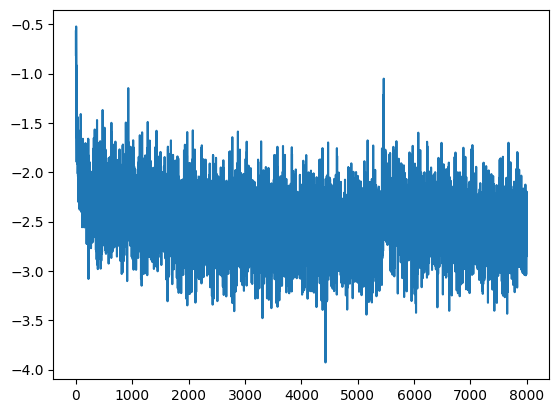

In [2]:
plt.plot(np.log10(loss_history))
plt.show()


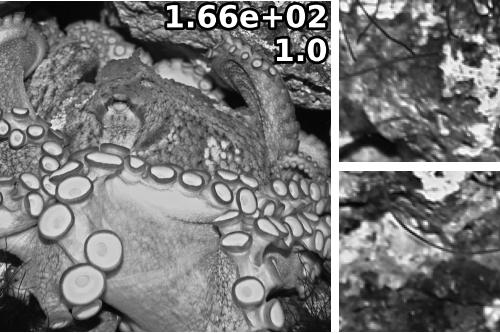
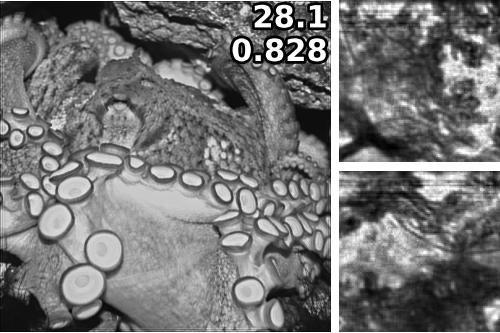

In [3]:
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

In [4]:
# approximate PSNR over history
np.mean(10*np.log10(loss_history[-800:]))

-26.09763322435461

In [5]:
# Import necessary modules
import sys
sys.path.append('/home/mzmighty17')
import torch
import torchOptics.optics as tt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import warnings
warnings.filterwarnings('ignore')
import torchOptics.models as tm

# Define dataset folder
folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/' 
# Define device
device = 'cuda' 
# Propagation distance
z = 2e-3 
# Pixel pitch metadata
meta = {'dx':[6.865e-6, 6.865e-6], 'wl':[612e-9]} 

# Define ShuffleUNet class
class ShuffleUNet(nn.Module):
    def __init__(self, num_down=5, num_features_init=16, norm='', last_layer_type='Hardtanh', last_layer_args=[0,1], pixel_shuffle=1, num_in=1, num_out=1, **kwargs):
        super().__init__()
        last_layer = getattr(nn, last_layer_type)(*last_layer_args)
        self.unshuffle = torch.nn.PixelUnshuffle(pixel_shuffle)
        self.shuffle = torch.nn.PixelShuffle(pixel_shuffle)
        self.net = tm.FinalPhaseOnlyUnet(num_down=num_down, num_features_init=num_features_init, num_in=num_in*pixel_shuffle**2, num_out=num_out*pixel_shuffle**2, norm=norm, last_layer=last_layer)
        
    def forward(self, x):
        return self.shuffle(self.net(self.unshuffle(x)))

# Define model hyperparameters
kwargs = {
    "model_kwargs1": {
        "in_channels": [1] + [32 for _ in range(10)] + [24],
        "biases": True,
        "last_layer_type": "Hardtanh",
        "last_layer_args": [0, 1],
        "pixel_shuffle": 1,
        "activations": "LeakyReLU"
    },
    "model_kwargs2": {
        "in_channels": [24] + [32 for _ in range(10)] + [1],
        "biases": True,
        "last_layer_type": "Hardtanh",
        "last_layer_args": [0, 1],
        "pixel_shuffle": 1,
        "activations": "LeakyReLU"
    }
}

# Initialize the model
net = ShuffleUNet(
    num_down=5, 
    num_features_init=16, 
    norm='', 
    last_layer_type='Hardtanh', 
    last_layer_args=[0, 1], 
    pixel_shuffle=1, 
    num_in=kwargs["model_kwargs1"]["in_channels"][0], 
    num_out=kwargs["model_kwargs2"]["in_channels"][-1]
)

# Define dataset and dataloader
dataset = tt.MultiImageDatasetImageio(
    folder, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomCrop((1024, 1024), pad_if_needed=True)
    ])
)
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Move the model to the specified device
net.to(device)

# Initialize loss history
loss_history = []

# Training loop
net.train()
for epoch in range(10):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output  # Output is amplitude-only field, note that the channel of the network output is 1.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())


0.0017: 100%|██████████| 800/800 [00:34<00:00, 23.28it/s]


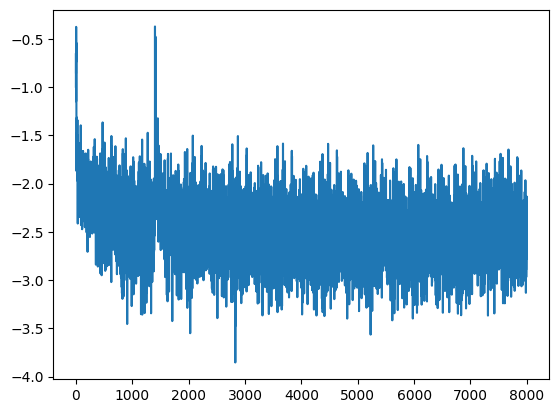

In [6]:
plt.plot(np.log10(loss_history))
plt.show()


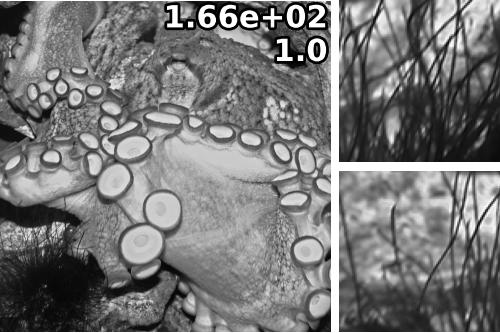
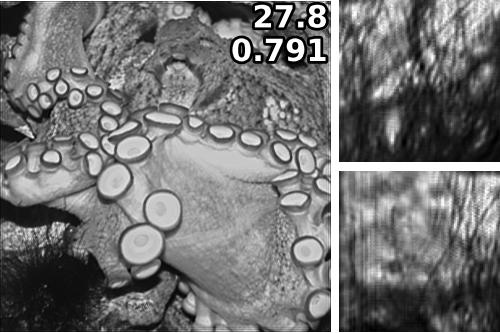

In [7]:
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

In [8]:
# approximate PSNR over history
np.mean(10*np.log10(loss_history[-800:]))

-25.22022796855612

In [9]:
# Define model hyperparameters
# More epochs?
kwargs = {
    "model_kwargs1": {
        "in_channels": [1] + [32 for _ in range(10)] + [24],
        "biases": True,
        "last_layer_type": "Hardtanh",
        "last_layer_args": [0, 1],
        "pixel_shuffle": 1,
        "activations": "LeakyReLU"
    },
    "model_kwargs2": {
        "in_channels": [24] + [32 for _ in range(10)] + [1],
        "biases": True,
        "last_layer_type": "Hardtanh",
        "last_layer_args": [0, 1],
        "pixel_shuffle": 1,
        "activations": "LeakyReLU"
    }
}

# Initialize the model
net = ShuffleUNet(
    num_down=5, 
    num_features_init=16, 
    norm='', 
    last_layer_type='Hardtanh', 
    last_layer_args=[0, 1], 
    pixel_shuffle=1, 
    num_in=kwargs["model_kwargs1"]["in_channels"][0], 
    num_out=kwargs["model_kwargs2"]["in_channels"][-1]
)

# Define dataset and dataloader
dataset = tt.MultiImageDatasetImageio(
    folder, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomCrop((1024, 1024), pad_if_needed=True)
    ])
)
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Move the model to the specified device
net.to(device)

# Initialize loss history
loss_history = []

# Training loop
net.train()
for epoch in range(100):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output  # Output is amplitude-only field, note that the channel of the network output is 1.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

0.0012: 100%|██████████| 800/800 [00:33<00:00, 23.73it/s]


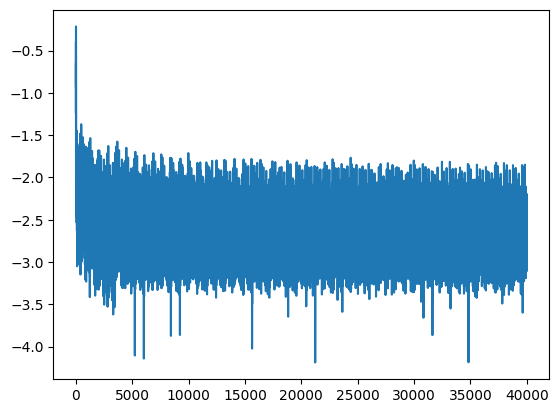

In [10]:
plt.plot(np.log10(loss_history))
plt.show()


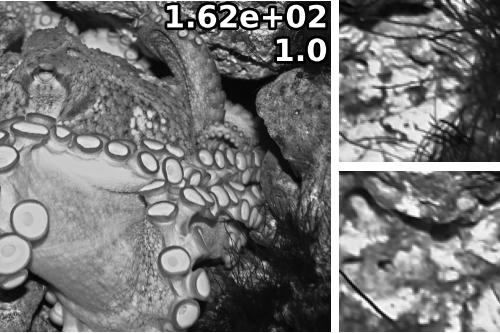
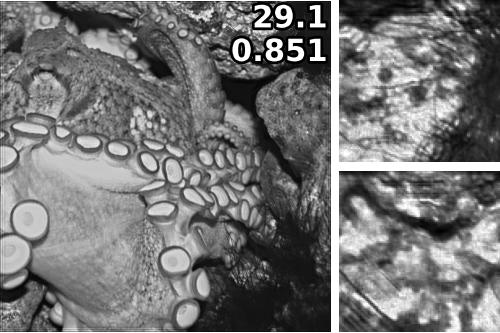

In [11]:
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

In [12]:
# approximate PSNR over history
np.mean(10*np.log10(loss_history[-800:]))

-26.99877602013351

In [13]:
!nvidia-smi

Wed Jun 26 11:46:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:68:00.0 Off |                  N/A |
|  0%   31C    P2             227W / 350W |  19198MiB / 24576MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--